In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/



In [2]:
!kaggle datasets download -d gti-upm/leapgestrecog

Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0
100% 2.13G/2.13G [00:28<00:00, 116MB/s] 
100% 2.13G/2.13G [00:28<00:00, 81.0MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/leapgestrecog.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout

In [9]:

train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/leapGestRecog/00',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)



Found 2000 files belonging to 10 classes.


In [25]:
import os
import random

test_files = tf.io.gfile.glob('/content/leapGestRecog/01/*/*')

selected_test_files = random.sample(test_files, 500)

def load_image(file_path):
    label = tf.strings.split(file_path, os.path.sep)[-2]
    label = tf.strings.regex_replace(label, r'[^0-9]', '')
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    return img, tf.strings.to_number(label, out_type=tf.int32)

validation_ds = tf.data.Dataset.from_tensor_slices(selected_test_files)
validation_ds = validation_ds.map(load_image)
validation_ds = validation_ds.batch(32)

In [26]:

def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [27]:
model=Sequential()
model.add(Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(10, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [29]:
history = model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 226ms/step - accuracy: 0.6123 - loss: 1.2708 - val_accuracy: 0.1440 - val_loss: nan
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.9880 - loss: 0.0396 - val_accuracy: 0.1100 - val_loss: nan
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.9983 - loss: 0.0048 - val_accuracy: 0.1900 - val_loss: nan
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.9956 - loss: 0.0227 - val_accuracy: 0.0320 - val_loss: nan
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.9974 - loss: 0.0042 - val_accuracy: 0.0860 - val_loss: nan
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.9994 - loss: 0.0027 - val_accuracy: 0.1920 - val_loss: nan
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.9864 - loss: 0.0594 - val_accuracy: 0.0860 - val_loss: nan
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - accuracy: 0.9954 - loss: 0.0167 - val_accuracy: 0.1580 - val_loss: na

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
The model predicts this image is: class_6


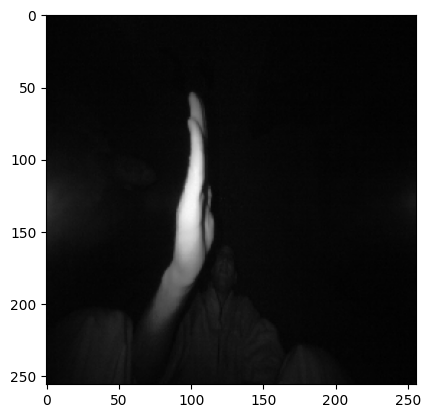

In [34]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

img_path = '/content/leapGestRecog/01/08_palm_moved/frame_01_08_0002.png'
img = image.load_img(img_path, target_size=(256, 256))
plt.imshow(img)

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0


predictions = model.predict(img_array)

predicted_class = np.argmax(predictions, axis=1)

class_names = ['class_1', 'class_2','class_3','class_4','class_5','class_6','class_7','class_8','class_9', 'class_10']
predicted_label = class_names[predicted_class[0]]
print(f"The model predicts this image is: {predicted_label}")